# ECE 47300 Assignment 11 Exercise

Your Name:

In this assignment, you will implement bandit algorithms.
Here, tasks entails the implementation and comparison of various algorithms for sampling the actions of a stochastic multi-actioned bandit. Each action yields rewards independently and identically distributed (i.i.d.) from a predetermined Bernoulli distribution. The objective is to maximize cumulative reward (or minimizing regret), a measure of the opportunity cost incurred by selecting suboptimal actions over the course of the bandit process.

In [2]:
# Fixing random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
randomSeed = 473
np.random.seed(randomSeed)


In [23]:
class BernoulliBanditEnvironment():
  def __init__(self, n_actions = 25):

    self.n_actions = n_actions
    self.actions_probs = np.random.beta(1,2,n_actions)

  def get_reward(self, action_index):
    rew = np.random.binomial(1, self.actions_probs[action_index])
    return rew


  def simulate_step(self, agent):
    action_index = agent.select_action()
    reward = self.get_reward(action_index)
    agent.update(action_index, reward)
    return action_index, reward

  def simulate(self, agent, n_steps, verbosity=1):
    cum_reward = 0
    for i in range(n_steps):
      action_index, reward = self.simulate_step(agent)
      cum_reward += reward
      if verbosity >= 1:
        print(
          f'Step = {i+1:02d}, '
          f'Action = {action_index:d}, '
          f'Reward = {reward:.0f}, '
          f'Cum reward = {cum_reward:.0f}, '
          f'Avg reward = {cum_reward/(i+1):.2f}, '
        )
    return cum_reward

np.random.seed(randomSeed)
env = BernoulliBanditEnvironment(5)
print('Reward distributions')
print(env.actions_probs)
print('\nRandom rewards for first distribution')
print([env.get_reward(0) for i in range(20)])

Reward distributions
[0.00862925 0.03242344 0.22020359 0.10769649 0.03991645]

Random rewards for first distribution
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
class OracleAgent:
  def __init__(self, env):
    self.optimal_action = np.argmax(env.actions_probs)

  def select_action(self):
    return self.optimal_action

  def update(self, action_index, reward):
    return self

  def __str__(self):
    return 'Oracle (best acheivable)'

np.random.seed(randomSeed)
env = BernoulliBanditEnvironment(5)
print('Reward distributions')
print(env.actions_probs)
oracle = OracleAgent(env)
env.simulate(oracle, n_steps=20, verbosity=1)

Reward distributions
[0.00862925 0.03242344 0.22020359 0.10769649 0.03991645]
Step = 01, Action = 2, Reward = 0, Cum reward = 0, Avg reward = 0.00, 
Step = 02, Action = 2, Reward = 1, Cum reward = 1, Avg reward = 0.50, 
Step = 03, Action = 2, Reward = 1, Cum reward = 2, Avg reward = 0.67, 
Step = 04, Action = 2, Reward = 0, Cum reward = 2, Avg reward = 0.50, 
Step = 05, Action = 2, Reward = 1, Cum reward = 3, Avg reward = 0.60, 
Step = 06, Action = 2, Reward = 1, Cum reward = 4, Avg reward = 0.67, 
Step = 07, Action = 2, Reward = 0, Cum reward = 4, Avg reward = 0.57, 
Step = 08, Action = 2, Reward = 0, Cum reward = 4, Avg reward = 0.50, 
Step = 09, Action = 2, Reward = 0, Cum reward = 4, Avg reward = 0.44, 
Step = 10, Action = 2, Reward = 0, Cum reward = 4, Avg reward = 0.40, 
Step = 11, Action = 2, Reward = 0, Cum reward = 4, Avg reward = 0.36, 
Step = 12, Action = 2, Reward = 1, Cum reward = 5, Avg reward = 0.42, 
Step = 13, Action = 2, Reward = 0, Cum reward = 5, Avg reward = 0.38, 

6

In [5]:
class EpsilonGreedyAgent:
    def __init__(self, n_actions, epsilon, init_value=0):
        self.n_actions = n_actions
        self.init_value = init_value
        self.action_counts = np.zeros(n_actions)
        self.action_value_func = init_value * np.ones(n_actions)  #Q_t
        self.epsilon = epsilon


    def select_action(self):
        if np.random.rand() < self.epsilon:
          return np.random.randint(0, self.n_actions)
        else:
          return np.argmax(self.action_value_func)

    def update(self, action_index, reward):
        action_count = self.action_counts[action_index]
        sum_rewards = action_count * self.action_value_func[action_index]
        new_avg_reward = (sum_rewards + reward) / (action_count + 1)

        self.action_counts[action_index] += 1
        self.action_value_func[action_index] = new_avg_reward
        return self

    def __str__(self):
        return f'$\epsilon$-Greedy($\epsilon={self.epsilon:.2f}$)'

# Try init_value = 0, 1 or 100
np.random.seed(randomSeed)
env = BernoulliBanditEnvironment(5)
print(f'Reward distributions\n: {env.actions_probs}')
epsilon_greedy = EpsilonGreedyAgent(len(env.actions_probs), epsilon=0.2)
env.simulate(epsilon_greedy, n_steps=20, verbosity=0)

Reward distributions
: [0.00862925 0.03242344 0.22020359 0.10769649 0.03991645]


0

# Exercise 1: Implement UCB Algorithm Agent (**40 points**)

The Upper Confidence Bound (UCB) is used in multi-armed bandit problems to balance the trade-off between exploration and exploitation. While the $\epsilon$-greedy algorithm selects actions randomly with a fixed probability, UCB takes a more sophisticated approach by incorporating uncertainty estimates into its action (also known as an arm in Bandit setup) selection strategy. It calculates an upper confidence bound for each action's value estimate, which represents the upper limit of the range within which the true value of the arm is likely to lie. By choosing the arm with the highest upper confidence bound, UCB aims to strike a balance between exploiting arms with high estimated values and exploring arms with high uncertainty. This makes UCB particularly effective in scenarios where the reward distributions of the arms are complex and uncertain.

More specifically, let $t$ denote the current timestep/round, let $\hat{v}_{i,t}$ denote the average reward for action $i$ at time $t$ (i.e., `action_value_func`), and let $n_{i,t}$ denote the number of times action $i$ has been taken up to time $t$. If one is computing a $(1-\delta)$ confidence interval around the estimate $\hat{v}_{i,t}$, then the upper part of this confidence interval for action $i$ would be at:

$$ U_{i,t}^{(\delta)} = \hat{v}_{i,t} + \sqrt{\frac{\log(\frac{1}{\delta})}{2 n_{i,t}}} .$$

Notice how the confidence interval shrinks as as $1/\sqrt{n_{i,t}}$, i.e., as $n_{i,t}\to \infty$, the bound will get closer and closer to $\hat{v}_{i,t}$. The more samples from this arm, the tighter the confidence interval.
Furthermore, note that the a $(1-\delta)$ confidence interval means that there is a $\delta$ chance of being outside this confidence interval. As time progresses, i.e., $t\to \infty$, we would want $\delta \to 0$ so that there is a diminishingly small chance of being outside the interval.

Thus, the UCB algorithm sets $\delta = \frac{1}{t^\alpha}$, where $\alpha$ is a hyperparameter that may be set but is usually set a little larger than 1. The paper below suggests a good default to be $\alpha=2$ but we will use $\alpha=4$:

$$ U_{i,t} = \hat{v}_{i,t} + \sqrt{\frac{\alpha \log t}{2 n_{i,t}}}.$$

Given this upper bound, the UCB algorithm always selects the action with the highest $U_{i,t}$ value. Thus, the algorithm can just keep track of $U_{i,t}$ and take the max instead of the greedy algorithm that just selects the max of $\hat{v}_{i,t}$ directly.

To initialize the UCB algorithm, we need that each arm has been pulled at least once (otherwise the bound cannot be computed since no data has been seen). Thus, the UCB algorithm must first pull each arm and then use these bounds. For simplicity, we can just pull the arms in sequential order for the first `n_actions` times, i.e., pull arm 0, 1, 2, etc. up to the total number of arms and then start using the UCB algorithm.

Finally, we will inherit the same update step from the `EpsilonGreedyAgent` to update the action value function which will be used in computing the UCB. Thus, you can just use the action value function within the select action method.
    
The algorithm plus more technical details including the proof of it's near optimality can be found in [these lecture notes on UCB](https://people.maths.bris.ac.uk/~maajg/teaching/stochopt/ucb.pdf).

**Task**: Implement `select_action` method in UCBAgent class based on the equation above and setting $\alpha=4$. Note that `total_pulls` represents the timestep/round $t$ in the equation above. (Also, note that the subscripts regarding $t$ in the equations mean the current values of those variables, i.e., you do not need to store past values of UCB or the action value function.)

As a sanity check, the last outputs should be as:
```
Step = 16, Action = 0, Reward = 0, Cum reward = 5, Avg reward = 0.31,
Step = 17, Action = 1, Reward = 0, Cum reward = 5, Avg reward = 0.29,
Step = 18, Action = 3, Reward = 0, Cum reward = 5, Avg reward = 0.28,
Step = 19, Action = 4, Reward = 0, Cum reward = 5, Avg reward = 0.26,
Step = 20, Action = 5, Reward = 1, Cum reward = 6, Avg reward = 0.30,
```

In [29]:
np.random.seed(randomSeed)

class UCBAgent(EpsilonGreedyAgent):
    def __init__(self, n_actions):
        self.n_actions = n_actions
        # self.init_value = init_value
        self.action_counts = np.zeros(n_actions)
        self.action_value_func = np.zeros(n_actions)
        self.ucb_values = np.zeros(n_actions)

    def select_action(self):
        total_pulls = sum(self.action_counts)
        ######### Your code #########
        # Pull each arm once at initialization
        if total_pulls < self.n_actions:
          return int(total_pulls)

        for i in range(self.n_actions):
          # After initialization select arm with maximum UCB
          # Calculate the upper confidence bound for each action
          u = np.sqrt((2 * np.log(total_pulls)) / self.action_counts[i])
          self.ucb_values[i] = self.action_value_func[i] + u

        # Select arm with maximum UCB
        selected_arm = np.argmax(self.ucb_values)

        ######### End  ##############
        return selected_arm


    def __str__(self):
        return f'UCB'

np.random.seed(randomSeed)
env = BernoulliBanditEnvironment(10)
print(f'Reward distributions\n: {env.actions_probs}')
UCB = UCBAgent(len(env.actions_probs))
env.simulate(UCB, n_steps=20, verbosity=1)

Reward distributions
: [0.00862925 0.03242344 0.22020359 0.10769649 0.03991645 0.40185367
 0.3472172  0.41848837 0.77318202 0.33280157]
Step = 01, Action = 0, Reward = 0, Cum reward = 0, Avg reward = 0.00, 
Step = 02, Action = 1, Reward = 0, Cum reward = 0, Avg reward = 0.00, 
Step = 03, Action = 2, Reward = 1, Cum reward = 1, Avg reward = 0.33, 
Step = 04, Action = 3, Reward = 0, Cum reward = 1, Avg reward = 0.25, 
Step = 05, Action = 4, Reward = 0, Cum reward = 1, Avg reward = 0.20, 
Step = 06, Action = 5, Reward = 0, Cum reward = 1, Avg reward = 0.17, 
Step = 07, Action = 6, Reward = 0, Cum reward = 1, Avg reward = 0.14, 
Step = 08, Action = 7, Reward = 1, Cum reward = 2, Avg reward = 0.25, 
Step = 09, Action = 8, Reward = 1, Cum reward = 3, Avg reward = 0.33, 
Step = 10, Action = 9, Reward = 0, Cum reward = 3, Avg reward = 0.30, 
Step = 11, Action = 2, Reward = 0, Cum reward = 3, Avg reward = 0.27, 
Step = 12, Action = 7, Reward = 0, Cum reward = 3, Avg reward = 0.25, 
Step = 13, A

6

# Exercise 2: Implement KL-UCB Algorithm Agent (**30 points**)

The KL-UCB (Kullback-Leibler Upper Confidence Bound) algorithm is another strategy for solving the multi-armed bandit problem.

Unlike the standard UCB algorithm, which uses confidence intervals based on the mean reward estimate and exploration term, KL-UCB employs confidence intervals derived from the Kullback-Leibler (KL) divergence between the empirical distribution of rewards for each arm and a reference distribution.
KL-UCB determines a tighter upper bound than UCB but requires solving a 1D optimization problem.
Other than computing the upper bound, the algorithm is the same as UCB.

First, we need to remember the KL divergence between two Bernoulli distributions with probabilities $p$ and $q$, respectively. The KL divergence $D_{\mathrm{KL}}$ for these Bernoulli distributions can be defined as follows:

$$ D_\mathrm{KL}(p, q) = p \log \frac{p}{q} + (1 - p) \log \frac{1 - p}{1 - q} .$$

The KL-UCB upper bound is defined as a maximization problem for finding the largest probability such that an particular inequality is satisfied:

$$ U_{i,t} = \max \left\{ p \in [0,1] : D_\mathrm{KL}(\hat{v}_{i,t}, p) \leq \frac{\log(t) + c \log(\log(t))}{n_{i,t}} \right\} $$

Or this can equivalently be written as:

$$ U_{i,t} = \arg\max_{p \in [0,1]} p \quad \text{s.t.}\quad D_\mathrm{KL}(\hat{v}_{i,t}, p) \leq \frac{\log(t) + c \log(\log(t))}{n_{i,t}} $$

For more details about the KL-UCB algorithm, you can read the following paper:
    [The KL-UCB Algorithm for Bounded Stochastic Bandits and Beyond](http://proceedings.mlr.press/v19/garivier11a/garivier11a.pdf)

## Implementation Details
To solve this problem, we can find the point between $\hat{v}_{i,t}$ and $1$ where the KL divergence is equal to the constraint. Because KL divergence is convex (when the first input is fixed), then searching for equality of the constraint between in the bounded region of $[\hat{v}_{i,t}, 1]$ will ensure that we solve this upper bound problem. We can thus transform the problem to the following:

$$ \arg\min_p \left(D_\mathrm{KL}(\hat{v}_{i,t}, p) - \frac{\log(t) + c \log(\log(t))}{n_{i,t}}\right)^2 \quad \text{s.t.}\quad p \in [\hat{v}_{i,t}, 1] $$

To do this, we can use the scipy function [`scipy.optimize.minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) with the objective above that seeks to make the constraint an equality (i.e., if the minimum of 0 is obtained, then the equality holds).

**Task 1**: Fill in `KL` and `objective_func` functions based on the equations above.

**Task 2: `select_action` function steps**:
   - Calculate total pulls.
   - If total pulls < total actions, select action equal to total pulls.
   - Otherwise:
     - Compute KL-UCB values for each action:
         - Extract the corresponding action value `v` and action count `n`.
         - Create the objective function using `v`, `total_pulls`, and `n`.
         - Define bounds of 1D optimization based on `v`.
         - call `scipy.optimize.minimize_scalar` with bounds to find optimum and use `options=dict(maxiter=5)`.
         - Store optimum KL-UCB value for the current action.
     - Select action with max KL-UCB.
    
As a sanity check, the last 5 outputs should be:
```
Step = 16, Action = 8, Reward = 1, Cum reward = 6, Avg reward = 0.38,
Step = 17, Action = 8, Reward = 1, Cum reward = 7, Avg reward = 0.41,
Step = 18, Action = 8, Reward = 1, Cum reward = 8, Avg reward = 0.44,
Step = 19, Action = 8, Reward = 1, Cum reward = 9, Avg reward = 0.47,
Step = 20, Action = 8, Reward = 0, Cum reward = 9, Avg reward = 0.45,
```

**Then make sure to run the last code to plot the results of all algorithms.** Note that epsilon greedy may be better than some UCB algorithms but KL-UCB should be the best.

In [35]:
import scipy.optimize

class KL_UCBAgent(UCBAgent):
  def __init__(self, n_actions):
    super().__init__(n_actions)

  def select_action(self):
    def KL(p, q, eps=1e-6):
      # Make sure the p and q values are between 0 and 1 exclusive
      p = np.clip(p, eps, 1-eps)
      q = np.clip(q, eps, 1-eps)
      ###### Your code ######
      # Compute the KL divergence given two Bernoulli probabilities p and q
      kl_value = (p * np.log(p/q)) + ((1-p) * np.log((1-p) / (1-q)))

      ###### End ######
      return kl_value

    # This function creates an objective function (i.e., it is a functional)
    def create_objective(v, t, n, c=3):
      # v is the action value of the $i$-th action
      # t is the timestep/total number of actions
      # n is the number of times that action $i$ has been pulled
      # c is a hyperparameter which we set to 3

      # Squared objective for minimization
      def objective_func(p):
        ###### Your code ######
        # Write this function based on the equation above
        #  using the local variables v, t, n and c along
        #  with the KL function above
        kl_value = KL(v, p)
        objective = (kl_value - ((np.log(t) + c*np.log(np.log(t))) / n))**2

        ###### End ######
        return objective

      # Returns the objective function
      return objective_func


    total_pulls = sum(self.action_counts)

    ###### Your code ######
    # Pull each arm once at initialization
    if total_pulls < self.n_actions:
      selected_arm = int(total_pulls)
    else:
    # After initialization select arm with maximum UCB
      # Calculate the KL-UCB for each action
      # 1) Create objective by extracting the value and count for this action
      # 2) Create the bounds
      # 3) Call minimize_scalar with this objective and bounds
      # 4) Extract the optimum from the returned optimizaiton result object

      for i in range(self.n_actions):
        v = self.action_value_func[i]
        n = self.action_counts[i]
        obj = create_objective(v, total_pulls, n)
        bound = [v, 1]
        min_scalar = scipy.optimize.minimize_scalar(obj, bounds=bound, options=dict(maxiter=5))
        self.ucb_values[i] = min_scalar.x




      # Select arm with maximum KL-UCB
      selected_arm = np.argmax(self.ucb_values)

    ###### End ######
    return selected_arm

  def __str__(self):
    return f'KL-UCB'

np.random.seed(randomSeed)
env = BernoulliBanditEnvironment(10)
print(f'Reward distributions\n: {env.actions_probs}')
kl_ucb_agent = KL_UCBAgent(len(env.actions_probs))
env.simulate(kl_ucb_agent, n_steps=20, verbosity=1)

Reward distributions
: [0.00862925 0.03242344 0.22020359 0.10769649 0.03991645 0.40185367
 0.3472172  0.41848837 0.77318202 0.33280157]
Step = 01, Action = 0, Reward = 0, Cum reward = 0, Avg reward = 0.00, 
Step = 02, Action = 1, Reward = 0, Cum reward = 0, Avg reward = 0.00, 
Step = 03, Action = 2, Reward = 1, Cum reward = 1, Avg reward = 0.33, 
Step = 04, Action = 3, Reward = 0, Cum reward = 1, Avg reward = 0.25, 
Step = 05, Action = 4, Reward = 0, Cum reward = 1, Avg reward = 0.20, 
Step = 06, Action = 5, Reward = 0, Cum reward = 1, Avg reward = 0.17, 
Step = 07, Action = 6, Reward = 0, Cum reward = 1, Avg reward = 0.14, 
Step = 08, Action = 7, Reward = 1, Cum reward = 2, Avg reward = 0.25, 
Step = 09, Action = 8, Reward = 1, Cum reward = 3, Avg reward = 0.33, 
Step = 10, Action = 9, Reward = 0, Cum reward = 3, Avg reward = 0.30, 
Step = 11, Action = 2, Reward = 0, Cum reward = 3, Avg reward = 0.27, 
Step = 12, Action = 7, Reward = 0, Cum reward = 3, Avg reward = 0.25, 
Step = 13, A

9

# Exercise 3:  Compare algorithms and plot the rewards (**30 points**)

**Make sure to run the following code to plot the results of all algorithms.** Note that epsilon greedy may be better than some UCB algorithms but KL-UCB should be the best.

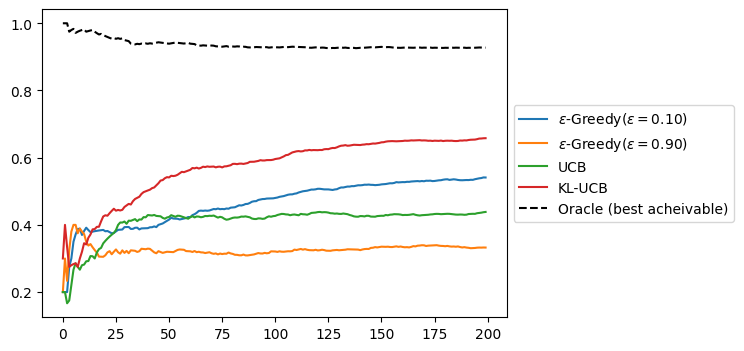

In [36]:
# Compare algorithms
n_actions = 100
n_steps = 200
agents = [
    EpsilonGreedyAgent(n_actions, epsilon=0.1),
    EpsilonGreedyAgent(n_actions, epsilon=0.9),
    UCBAgent(n_actions),
    KL_UCBAgent(n_actions)
]
label_list = []
mean_reward_tensor = []
for seed in range(10):
    mean_reward_list = []
    np.random.seed(randomSeed + seed)
    env = BernoulliBanditEnvironment(n_actions)
    #print([dist.probs.item() for dist in env.reward_dists])
    for agent in agents + [OracleAgent(env)]:
        np.random.seed(randomSeed*1000 + seed)
        mean_reward = []
        cum_reward = 0
        for step in range(n_steps):
            _, reward = env.simulate_step(agent)
            cum_reward += reward
            mean_reward.append(cum_reward / (step + 1))
        mean_reward_list.append(mean_reward)
        if seed == 0:
            label_list.append(str(agent))
    mean_reward_tensor.append(mean_reward_list)

# Plot averages
mean_reward_tensor = np.array(mean_reward_tensor)
average_reward_agent = np.mean(mean_reward_tensor, axis=0)
fig = plt.figure(figsize=(6,4), dpi=100)
for x, label in zip(average_reward_agent, label_list):
    if label == 'Oracle (best acheivable)':
        plt.plot(x, label=label, linestyle='--', color='black')
    else:
        plt.plot(x, label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
